# Final TCGA Model Training/Hyperparameter Opotimisation and validation against CGGA data

### Importing Libraries

In [1]:
import os

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D

import torch
import torch.nn as nn
from torch.utils.data import WeightedRandomSampler

from scipy.special import expit, logit
from scipy.stats import zscore

from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, average_precision_score,
                             roc_curve, precision_recall_curve, balanced_accuracy_score)
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
from sklearn.base import clone

from sksurv.metrics import cumulative_dynamic_auc
from sksurv.util import Surv

from xgboost import XGBClassifier

from skopt import BayesSearchCV
from skopt.space import Real, Integer

from skorch import NeuralNetClassifier
from skorch.callbacks import EarlyStopping, Callback

from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.pipeline import Pipeline

from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test

from statsmodels.stats.multitest import multipletests

from itertools import product

from typing import Dict, List, Tuple

from dcurves import dca, plot_graphs

### Defining ANN Helper Classes

In [2]:
#######################################
### Defining Helper Classes for ANN ###
#######################################

# Focal Loss class for enabling training focused on the difficult to predict class
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=5, reduction='mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
    
    def forward(self, logits, targets):
        targets = targets.view(-1,1).type_as(logits)
        bce_loss = nn.functional.binary_cross_entropy_with_logits(logits, targets, reduction='none')
        pt = torch.exp(-bce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * bce_loss
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss
        
# Class for the ANN model (binary classification)
class DeepBinary(nn.Module):
    def __init__(self, hidden_dim=64, num_layers=4, dropout_rate=0.25):
        super().__init__()
        layers = []
        layers.append(nn.LazyLinear(hidden_dim))
        layers.append(nn.LayerNorm(hidden_dim))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(dropout_rate))

        for _ in range(num_layers - 1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.LayerNorm(hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))

        layers.append(nn.Linear(hidden_dim, 1))  # final logit
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# Defining NeuralNet class which will be necessary for use with skorch and skopt
class NeuralNetBinaryClassifier(NeuralNetClassifier):
    def predict_proba(self, X):
        logits = self.forward(X).detach().cpu().numpy()
        probs = expit(logits)
        return np.hstack((1 - probs, probs))

############################################
### Defining Deep Learning Skorch Set up ###
############################################

# Defining the base ANN model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = NeuralNetBinaryClassifier(
    module = DeepBinary,
    criterion = FocalLoss,
    criterion__alpha = 0.25,
    criterion__gamma = 2.0,
    max_epochs = 500,
    lr = 1e-3,
    optimizer = torch.optim.Adam,
    optimizer__weight_decay=1e-4,
    batch_size = 128,
    device = device,
    verbose = 0,
    callbacks=[
        EarlyStopping(
            monitor='valid_loss',
            threshold=0.01,
            patience=100,
            lower_is_better=True,
            load_best=False
        )
    ]
)

### Defining Hyperparameter Search Spaces

In [3]:
# Defining the ANN search space
deep_search_space = {
    "lr": Real(0.000001, 0.01, prior="log-uniform"),
    "module__hidden_dim": Integer(4, 256),
    "module__num_layers": Integer(1, 4),
    "module__dropout_rate": Real(0.0, 0.5),
    "criterion__alpha": Real(0.0, 0.5),
    "criterion__gamma": Real(1.0, 7.0)
}

############################################
### Defining non ANN model search spaces ###
############################################

search_spaces = {
    "SVM": (
        SVC(probability=True, class_weight="balanced", kernel = 'rbf', gamma='scale', random_state=42),
        {
            "C": Real(0.001, 1.0, prior="log-uniform")
        }
    ),
    "RandomForest": (
        RandomForestClassifier(class_weight="balanced", random_state=42),
        {
            "n_estimators": Integer(50, 500),
            "max_depth": Integer(2, 20),
            "min_samples_split": Integer(2, 20),
            "min_samples_leaf": Integer(1, 10),
        }
    ),
    "XGBoost": (
        XGBClassifier(eval_metric="logloss", random_state=42),
        {
            "n_estimators": Integer(50, 500),
            "max_depth": Integer(2, 20),
            "learning_rate": Real(0.001, 0.1, prior="log-uniform"),
            "subsample": Real(0.5, 1.0),
            "colsample_bytree": Real(0.5, 1.0),
            "scale_pos_weight": Real(1.0, 10.0)
        }
    ),
    "LogisticRegression": (
        LogisticRegression(max_iter=5000, class_weight="balanced", solver="lbfgs"),
        {
            "C": Real(0.001, 1.0, prior="log-uniform")
        }
    )
}

### Defining utility functions

In [4]:
##################################
### Defining Utility Functions ###
##################################

# Function to compute metrics
def compute_metrics(y_true, probs, threshold=0.5):
    y_pred = (probs >= threshold).astype(int)
    return {'accuracy': accuracy_score(y_true, y_pred),
            'precision': precision_score(y_true, y_pred, zero_division=0),
            'recall': recall_score(y_true, y_pred),
            'f1': f1_score(y_true, y_pred, zero_division=0),
            'roc_auc': roc_auc_score(y_true, probs),
            'pr_auc': average_precision_score(y_true, probs)}

# Alternative Function for tuning on log-rank z
def tune_threshold_by_logrank(
    probs_train: np.ndarray,
    time_train: np.ndarray,
    event_train: np.ndarray,
) -> tuple[float, float]:
    
    probs_train = np.asarray(probs_train, float).ravel()
    time_train  = np.asarray(time_train,  float).ravel()
    event_train = np.asarray(event_train, bool).ravel()

    # Candidate thresholds from fixed quantiles
    qs = np.linspace(0.3, 0.7, 41)
    cands = np.unique(np.quantile(probs_train, qs))
    best_thr  = float(np.median(probs_train))
    best_stat = -np.inf
    found     = False

    for thr in cands:
        hi = probs_train >= thr
        lo = ~hi
        if hi.sum() == 0 or lo.sum() == 0:
            continue
        try:
            lr = logrank_test(
                time_train[hi], time_train[lo],
                event_observed_A=event_train[hi],
                event_observed_B=event_train[lo],
            )
            chi2 = float(lr.test_statistic)
            if np.isfinite(chi2) and chi2 > best_stat:
                best_stat = chi2
                best_thr  = float(thr)
                found     = True
        except Exception:
            continue

    if not found:
        # fallback: median threshold, 0 separation
        return float(np.median(probs_train)), 0.0

    return best_thr, best_stat

### Defining Plotting Functions

In [5]:
# Function to plot mean ROC curves
def plot_mean_roc(curves_summary):
    plt.figure(figsize=(6,5))
    for model_name, (fpr, mean_tpr) in curves_summary['roc'].items():
        plt.plot(fpr, mean_tpr, label=f'{model_name}')
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.title("CV Pooled ROC-Curves", fontsize=18)
    plt.tick_params(axis="both", labelsize=14)
    plt.legend()
    plt.tight_layout()
    plt.show()
    plt.close()

# Function to plot mean PR curves
def plot_mean_pr(curves_summary, y_CGGA):
    plt.figure(figsize=(6,5))
    for model_name, (recall, mean_prec) in curves_summary['pr'].items():
        plt.plot(recall, mean_prec, label=f'{model_name}')
    plt.hlines(y_CGGA.sum()/len(y_CGGA), 0, 1, colors="k", linestyles="--", label="Baseline")
    plt.xlabel('Recall', fontsize=16)
    plt.ylabel('Precision', fontsize=16)
    plt.title("CV Pooled PR-Curves", fontsize=18)
    plt.tick_params(axis="both", labelsize=14)
    plt.legend()
    plt.tight_layout()
    plt.show()
    plt.close()

In [6]:
def plot_km_curves(survival_results, max_years=5):
    risk_labels = {0: "Low Risk", 1: "High Risk"}
    model_list = list(survival_results.keys())
    colours = ["#C190F0", "#35AB6A"]

    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    axes = axes.flatten()
    logrank_ps = []
    iteration = 0
    for idx, model_name in enumerate(model_list):
        ax = axes[idx]

        # Pool all folds
        dfs = []
        for OS_val, pred_dict in survival_results[model_name]:
            temp = OS_val.copy()
            temp["pred_class"] = pred_dict["class"]
            dfs.append(temp)
        pooled_df = pd.concat(dfs, ignore_index=True).dropna()

        high = pooled_df[pooled_df["pred_class"] == 1]
        low  = pooled_df[pooled_df["pred_class"] == 0]
        lr_res = logrank_test(
            high["OS.time"], low["OS.time"],
            event_observed_A=high["OS"], event_observed_B=low["OS"]
        )
        p_val = lr_res.p_value
        logrank_ps.append(p_val)
        ax.set_title(f"{model_name}\nLog-Rank p = {logrank_ps[iteration]:.2e}", fontsize=16)
        iteration += 1
        # KM curves
        kmf = KaplanMeierFitter()
        for cls in [0, 1]:
            mask = pooled_df["pred_class"] == cls
            n_value = mask.sum()
            kmf.fit(
                durations=pooled_df.loc[mask, "OS.time"] / 365,
                event_observed=pooled_df.loc[mask, "OS"],
                label=f"{risk_labels[cls]} (n={n_value})"
            )
            kmf.plot_survival_function(ax=ax, ci_show=True, color=colours[cls])

        ax.set_xlim(0, max_years)
        ax.set_xlabel("Time (years)", fontsize=16)
        ax.set_ylabel("Survival probability", fontsize=16)
        ax.tick_params(axis="both", labelsize=14)
        ax.legend(fontsize=10,loc="lower left",edgecolor="black")

    # Remove unused subplots
    for j in range(idx + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()
    plt.close()

def plot_forest(survival_results, metrics_results):
    """
    Plot Concordance (left) | HR (forest) (middle) | metrics table (right).
    Model names appear on the leftmost axis (concordance). Continuous separators
    span the full figure so lines meet across panels.
    """
    results = []
    model_list_local = list(survival_results.keys())

    # Fit Cox model per model and collect HR / CI / p and c-index (assumes cph.concordance_index_ set)
    for model_name in model_list_local:
        dfs = []
        for OS_val, probs_dict in survival_results[model_name]:
            temp = OS_val.copy()
            temp["score"] = probs_dict["score"]
            dfs.append(temp)
        pooled_df = pd.concat(dfs, ignore_index=True).dropna()

        cph_df = pooled_df.rename(columns={"OS.time": "time", "OS": "event"})
        cph = CoxPHFitter(penalizer=0.05, l1_ratio=0.0)
        cph.fit(cph_df, duration_col="time", event_col="event", robust=True)
        summary = cph.summary.loc["score"]

        c_index = getattr(cph, "concordance_index_", None)

        results.append({
            'Model': model_name,
            'HR': summary['exp(coef)'],
            'CI_lower': summary['exp(coef) lower 95%'],
            'CI_upper': summary['exp(coef) upper 95%'],
            'p': summary['p'],
            'cindex': c_index
        })

    sig_df = pd.DataFrame(results)

    # Build metrics table
    rows = []
    for model_name in model_list_local:
        row = {'Model': model_name}
        ms = metrics_results.get(model_name, {})
        if ms:
            def to_tuple(x):
                return x if isinstance(x, (list, tuple, np.ndarray)) else (x, np.nan)
            row.update({
                'accuracy_mean': to_tuple(ms.get('accuracy', (np.nan, np.nan)))[0],
                'accuracy_std' : to_tuple(ms.get('accuracy', (np.nan, np.nan)))[1],
                'precision_mean': to_tuple(ms.get('precision', (np.nan, np.nan)))[0],
                'precision_std' : to_tuple(ms.get('precision', (np.nan, np.nan)))[1],
                'recall_mean': to_tuple(ms.get('recall', (np.nan, np.nan)))[0],
                'recall_std' : to_tuple(ms.get('recall', (np.nan, np.nan)))[1],
                'f1_mean': to_tuple(ms.get('f1', (np.nan, np.nan)))[0],
                'f1_std' : to_tuple(ms.get('f1', (np.nan, np.nan)))[1],
                'roc_auc_mean': to_tuple(ms.get('roc_auc', (np.nan, np.nan)))[0],
                'roc_auc_std' : to_tuple(ms.get('roc_auc', (np.nan, np.nan)))[1],
                'pr_auc_mean': to_tuple(ms.get('pr_auc', (np.nan, np.nan)))[0],
                'pr_auc_std' : to_tuple(ms.get('pr_auc', (np.nan, np.nan)))[1],
            })
        rows.append(row)
    metrics_df = pd.DataFrame(rows)

    # Merge and compute significance
    sig_df = pd.merge(sig_df, metrics_df, on="Model", how="left")
    sig_df["Sig"] = sig_df["p"] < 0.05
    # Keep original order
    ordered_models = [m for m in model_list_local if m in sig_df["Model"].values]
    df_forest = sig_df.set_index("Model").loc[ordered_models].reset_index()

    # y positions
    n_models = len(df_forest)
    y = np.arange(n_models)

    # Figure & GridSpec (left: concordance, mid: HR, right: table)
    fig = plt.figure(figsize=(14, 6))
    gs = gridspec.GridSpec(1, 3, width_ratios=[1.0, 1.0, 3.0], wspace=0.075)

    # Create axes in the new order: concordance left, HR middle, table right
    ax_cindex = fig.add_subplot(gs[0])
    ax_hr = fig.add_subplot(gs[1])
    ax_table = fig.add_subplot(gs[2])
    ax_table.set_axis_off()

    # ---------- Concordance (left) ----------
    ax_cindex.barh(y, df_forest["cindex"], align='center', height=0.6, zorder=2,
                   edgecolor="black", color="#7FC97F")
    ax_cindex.set_xlim(0, 1)
    ax_cindex.set_xlabel("C-index", fontsize=12)
    ax_cindex.set_xticks(ticks=[0.0,0.2,0.4,0.6,0.8,1.0])
    # put model names on the LEFT axis (concordance)
    ax_cindex.set_yticks(y)
    ax_cindex.set_yticklabels(df_forest["Model"].tolist(), fontsize=11)
    ax_cindex.yaxis.set_ticks_position('left')
    ax_cindex.yaxis.set_label_position('left')
    ax_cindex.tick_params(axis='y', labelleft=True)
    ax_cindex.invert_yaxis()
    ax_cindex.set_title("Concordance", fontsize=12, fontweight='bold')
    ax_cindex.tick_params(axis='x', labelsize=10)

    for yi, cval in zip(y, df_forest["cindex"]):
        # annotate c-index values to the right of bars
        if not np.isnan(cval):
            ax_cindex.text(cval + 0.01, yi, f"{cval:.2f}", va='center', fontsize=9)

    # ---------- Hazard Ratio (forest) (middle) ----------
    hr_err_low = df_forest["HR"] - df_forest["CI_lower"]
    hr_err_high = df_forest["CI_upper"] - df_forest["HR"]
    ax_hr.errorbar(df_forest["HR"], y,
                   xerr=[hr_err_low, hr_err_high],
                   fmt='none', ecolor='black', capsize=5, elinewidth=1.5, capthick=1.5, zorder=1)
    ax_hr.scatter(df_forest["HR"], y,
                  c=df_forest["Sig"], cmap='Set2_r',
                  linewidths=1.5, edgecolors='black', zorder=2, vmin=0, s=150)

    # hide y labels on the middle HR axis (they are on the left axis)
    ax_hr.set_yticks(y)
    ax_hr.set_yticklabels([])
    ax_hr.tick_params(axis='y', length=0)

    # set consistent y-limits on all axes then invert for plotting order
    ymin, ymax = -0.5, n_models - 0.5
    ax_cindex.set_ylim(ymin, ymax)
    ax_hr.set_ylim(ymin, ymax)
    ax_table.set_ylim(ymin, ymax)
    ax_cindex.invert_yaxis()
    ax_hr.invert_yaxis()
    ax_table.invert_yaxis()

    ax_hr.axvline(1, color='red', linestyle='--')
    hr_max = np.nanmax(df_forest[["CI_upper", "HR"]].values) * 1.1
    hr_xlim = max(2, hr_max)
    ax_hr.set_xlim(0, hr_xlim)
    ax_hr.set_xlabel("Hazard Ratio (HR)", fontsize=12)
    ax_hr.set_title("Forest Plot", fontsize=14, fontweight='bold')
    ax_hr.tick_params(axis='x', labelsize=10)

    # ---------- Metrics table (text) (right) ----------
    headers = ["HR", "p", "ACC", "PRC", "REC", "F1", "ROC", "AP"]
    col_x = np.linspace(0, 0.7, len(headers))

    # header: just above the top row (top is at y = 0 after inversion)
    header_y = ymin - 0.05
    for x, h in zip(col_x, headers):
        ax_table.text(x, header_y, h, fontsize=12, fontweight="bold", ha="center", va="bottom")

    # metric rows aligned with y positions
    for row_idx, row in enumerate(df_forest.itertuples(), start=0):
        values = [
            f"{row.HR:.2f}",
            f"{row.p:.2e}",
            f"{row.accuracy_mean:.2f}",
            f"{row.precision_mean:.2f}",
            f"{row.recall_mean:.2f}",
            f"{row.f1_mean:.2f}",
            f"{row.roc_auc_mean:.2f}",
            f"{row.pr_auc_mean:.2f}"
        ]
        for x, val in zip(col_x, values):
            ax_table.text(x, row_idx, val, fontsize=10, ha="center", va="center")

    # horizontal separators for readability
    for yi in range(0,5):
        ax_hr.hlines(yi + 0.5, xmin=ax_hr.get_xlim()[0], xmax=ax_hr.get_xlim()[1],
                     colors='lightgray', linestyles='--', linewidth=1, zorder=0)
        ax_cindex.hlines(yi + 0.5, xmin=ax_cindex.get_xlim()[0], xmax=ax_cindex.get_xlim()[1],
                         colors='lightgray', linestyles='--', linewidth=1, zorder=0)

    # ---------- Continuous separators across all panels ----------
    # Draw full-figure separators so they meet across axes
    fig.canvas.draw()
    x_left_fig = ax_cindex.get_position().x0
    x_right_fig = ax_table.get_position().x1
    for yi in range(0,5):
        y_data = yi + 0.5
        _, y_disp = ax_cindex.transData.transform((0, y_data))
        _, y_fig = fig.transFigure.inverted().transform((0, y_disp))
        line = Line2D([x_left_fig, x_right_fig], [y_fig, y_fig], transform=fig.transFigure,
                      color='lightgray', linestyle='--', linewidth=1, zorder=0)
        fig.add_artist(line)

    # finalize
    plt.show()
    plt.close()

In [7]:
def plot_time_roc(summary_df):
    plt.figure(figsize=(6,5))
    ensemble_df = summary_df[["y_true","OS.time","OS","prob_Ensemble","pred_Ensemble"]].copy()
    def time_1(x):
        if x <= 365*1:
            return 1
        else:
            return 0
    def time_3(x):
        if x <= 365*3:
            return 1
        else:
            return 0
    def time_5(x):
        if x <= 365*5:
            return 1
        else:
            return 0

    ensemble_df["1_Srv"] = ensemble_df["OS.time"].apply(time_1)
    ensemble_df["3_Srv"] = ensemble_df["OS.time"].apply(time_3)
    ensemble_df["5_Srv"] = ensemble_df["OS.time"].apply(time_5)

    df_1 = ensemble_df[ensemble_df["1_Srv"]==1]
    df_3 = ensemble_df[ensemble_df["3_Srv"]==1]
    df_5 = ensemble_df[ensemble_df["5_Srv"]==1]

    fpr1, tpr1, _ = roc_curve(df_1['y_true'], df_1["prob_Ensemble"])
    fpr3, tpr3, _ = roc_curve(df_3['y_true'], df_3["prob_Ensemble"])
    fpr5, tpr5, _ = roc_curve(df_5['y_true'], df_5["prob_Ensemble"])

    auc1 = roc_auc_score(df_1['y_true'], df_1["prob_Ensemble"])
    auc3 = roc_auc_score(df_3['y_true'], df_3["prob_Ensemble"])
    auc5 = roc_auc_score(df_5['y_true'], df_5["prob_Ensemble"])

    plt.plot(fpr1, tpr1, label=f"1Yr Survival (AUC={auc1:.2f})")
    plt.plot(fpr3, tpr3, label=f"3Yr Survival (AUC={auc3:.2f})")
    plt.plot(fpr5, tpr5, label=f"5Yr Survival (AUC={auc5:.2f})")

    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.title("Ensemble ROC Over Time", fontsize=18)
    plt.tick_params(axis="both", labelsize=14)
    plt.legend()
    plt.tight_layout()
    plt.show()
    plt.close()

In [8]:
def plot_decision_curve(oof_df):
    oof_df = oof_df.dropna().copy()
    oof_df["OS.years"] = oof_df["OS.time"]/365
    oof_df[["prob_Ensemble"]] = MinMaxScaler().fit_transform(oof_df[["prob_Ensemble"]])
    model_prob_cols = [c for c in oof_df.columns if c.startswith("prob_")]
    df_dca = dca(data=oof_df,outcome='OS',modelnames=model_prob_cols, thresholds=np.arange(0,0.80,0.01),time_to_outcome_col='OS.years',time=5)
    models_in_plot = [m for m in df_dca["model"].unique()]
    tab10 = plt.get_cmap("tab10")
    palette = [tab10(i % 10) for i in range(len(models_in_plot))]
    plt.figure(figsize=(6, 5))
    plot_graphs(plot_df=df_dca, graph_type='net_benefit',y_limits=[-0.05,0.5],color_names=palette,linewidths=[2],linestyles=['-','-','-','-','-','-',':','--'])
    plt.xlabel("Threshold Probability",fontsize=16)
    plt.yticks(ticks=[0.0,0.1,0.2,0.3,0.4,0.5],labels=[0.0,0.1,0.2,0.3,0.4,0.5])
    plt.ylabel("Net Benefit",fontsize=16)
    plt.tick_params(axis="both", labelsize=14)
    plt.grid(visible=False)
    plt.legend()
    plt.tight_layout()
    plt.show()
    plt.close()

### Defining training function

In [9]:
def train_evaluate_model(random_state=42,inner_folds=3,inner_iterations=25,ANN_iterations=25):

    # Stetting variables
    RANDOM_STATE = random_state
    INNER_FOLDS = inner_folds
    N_ITER_INNER = inner_iterations
    N_ITER_ANN = ANN_iterations
    N_JOBS = -1

    # Downloading TCGA Data (Training)
    TCGA_URL = "./iMAT_integrated_data/TCGA_iMAT_integrated_df_20.csv"
    TCGA = pd.read_csv(TCGA_URL).drop(columns=["sample"])
    TCGA = TCGA.dropna()
    TCGA_OS = TCGA[["OS", "OS.time"]]

    le = LabelEncoder().fit(TCGA["OS"])

    X_TCGA = TCGA.drop(columns = ["OS", "OS.time"])
    y_TCGA = le.transform(TCGA["OS"])

    # Downloading CGGA Data (Validation)
    CGGA_URL = "./CGGA_Data/CGGA_Tidied_Integrated.csv"
    CGGA = pd.read_csv(CGGA_URL)
    CGGA = CGGA.dropna()
    CGGA_IDs = CGGA['CGGA_ID'].values
    CGGA = CGGA.drop(columns=["CGGA_ID"])
    CGGA_OS = CGGA[["OS", "OS.time"]]

    X_CGGA = CGGA.drop(columns = ["OS", "OS.time"])
    y_CGGA = le.transform(CGGA["OS"])

    # Preparing storage dictionaries
    models_info = {name: {'estimator': m, 'space': s} for name, (m, s) in search_spaces.items()}
    models_info['ANN'] = {'estimator': net, 'space': deep_search_space}

    # Setting up event and time datasets
    TCGA_event = TCGA_OS['OS'].values.astype(bool)
    TCGA_time  = TCGA_OS['OS.time'].values.astype(float)

    CGGA_event  = CGGA_OS['OS'].values.astype(bool)
    CGGA_time   = CGGA_OS['OS.time'].values.astype(float)

    # Setting up results dataframes
    probs_train_store = {}
    probs_results = {'y_true':y_CGGA}
    class_results = {'y_true':y_CGGA}
    metrics_results = {}
    roc_results = {}
    pr_results = {}

    for model_name, info in models_info.items():
        print(f'\nTuning and Fitting: {model_name}')
        base = clone(info['estimator'])
        space = info['space']

        # Defining the pipeline for the model
        pipe = Pipeline([
            ('low_var', VarianceThreshold()),
            ('scaler', StandardScaler()),
            ('smote', SMOTE(random_state=RANDOM_STATE,sampling_strategy=0.5)),
            ('clf', base)
        ])


        # prefix search space
        space_prefixed = {f'clf__{k}': v for k, v in space.items()}


        #Selecting iterations
        n_iter = N_ITER_ANN if model_name == 'ANN' else N_ITER_INNER
        n_jobs = 1 if model_name == 'ANN' else N_JOBS

        opt=BayesSearchCV(
            estimator=pipe,
            search_spaces=space_prefixed,
            n_iter=n_iter,
            scoring='average_precision',
            cv=INNER_FOLDS,
            random_state=RANDOM_STATE,
            n_jobs=n_jobs,
            refit=True,
            optimizer_kwargs={'n_initial_points': 100}
        )

        # Fitting
        fit_X = X_TCGA.astype(np.float32) if model_name == 'ANN' else X_TCGA
        opt.fit(fit_X, y_TCGA)

        # Plotting Loss Curves
        if model_name == "ANN":
            best = opt.best_estimator_
            
            # skorch Net is inside the pipeline as step 'clf'
            net_trained = best.named_steps['clf']

            # Access the training history
            history = net_trained.history_

            # Extract values
            train_losses = history[:, 'train_loss']
            valid_losses = history[:, 'valid_loss']
            plt.figure(figsize=(6,4))
            plt.plot(train_losses, label="Train Loss")
            if valid_losses is not None:
                plt.plot(valid_losses, label="Valid Loss")
            plt.xlabel("Epoch")
            plt.ylabel("Loss")
            plt.title(f"ANN Loss Curve")
            plt.legend()
            plt.grid(alpha=0.3)
            plt.show()
            plt.close()

        print(f"Best params for {model_name}: {opt.best_params_}")

        # In this case fit base estimator inside the pipeline without search
        best = opt.best_estimator_

        
        # Tuning for best threshold:
        train_preds_input = fit_X.astype(np.float32) if model_name == 'ANN' else fit_X
        probs_train = best.predict_proba(train_preds_input)[:, 1].ravel()

        # Store training probs
        probs_train_store[model_name] = probs_train

        # Tuning threshold on training data
        thr, thr_best = tune_threshold_by_logrank(probs_train=probs_train, time_train=TCGA_time,event_train=TCGA_event)
        print(f"Tuned threshold for {model_name}: {thr:.2f} (Log-Rank Chi2={thr_best:.3f})")

        # Predict proba on the test set
        test_X = X_CGGA.astype(np.float32) if model_name == 'ANN' else X_CGGA
        probs = best.predict_proba(test_X)[:, 1].ravel()

        # Storing testing probs
        probs_results[model_name] = probs
        
        # Storing out of fold predictions
        model_predictions = (probs >= thr).astype(int)
        class_results[model_name] = model_predictions

        # Compute per-fold metrics and curves
        m = compute_metrics(y_CGGA, probs, threshold=thr)
        metrics_results[model_name] = m
        fpr, tpr, _ = roc_curve(y_CGGA, probs)
        prec, rec, _ = precision_recall_curve(y_CGGA, probs)
        roc_results[model_name] = (fpr, tpr)
        pr_results[model_name] = (rec, prec)

        print(f"{model_name}: AP={m['pr_auc']:.3f}, ROC AUC={m['roc_auc']:.3f}")

    # Computing Ensemble predictions for this fold against the train set for threshold tuning
    model_list = ["SVM","RandomForest","XGBoost","LogisticRegression","ANN"]
    L_train = np.vstack([probs_train_store[m]for m in model_list]).T
    std_scaler = StandardScaler().fit(L_train)
    Z_train = std_scaler.transform(L_train)

    probs_train_df = pd.DataFrame(Z_train, columns=model_list)
    probs_train_df["OS"] = TCGA_event
    probs_train_df["OS.time"] = TCGA_time

    cph = CoxPHFitter(penalizer=0.05, l1_ratio=0.0)
    cph.fit(probs_train_df, duration_col="OS.time", event_col="OS", robust=True)

    beta_vec = cph.params_[model_list].values
    eta_train = Z_train @ beta_vec               

    # Threshold tuning on TRAIN
    thr_ens, thr_ens_best = tune_threshold_by_logrank(eta_train, TCGA_time, TCGA_event)

    probs_train_store['Ensemble'] = eta_train
    print(f"Tuned threshold for Ensemble: {thr_ens:.2f} (Log-Rank Chi2={thr_ens_best:.3f})")

    # Computing Ensemble predictions for this fold against the test set
    L_test = np.vstack([probs_results[m] for m in model_list]).T
    Z_test = std_scaler.transform(L_test)
    eta_test = Z_test @ beta_vec

    probs_results['Ensemble'] = eta_test

    #Calculating ensemble predictions
    ensemble_preds = (eta_test >= thr_ens).astype(int)
    class_results['Ensemble'] = ensemble_preds

    # Store ensemble metrics and curves
    m_ens = compute_metrics(y_CGGA, eta_test, threshold=thr_ens)
    metrics_results['Ensemble'] = (m_ens)
    fpr, tpr, _ = roc_curve(y_CGGA, eta_test)
    prec, rec, _ = precision_recall_curve(y_CGGA, eta_test)
    roc_results['Ensemble'] = (fpr, tpr)
    pr_results['Ensemble'] = (rec, prec)
    
    probs_df = pd.DataFrame(probs_results)
    class_df = pd.DataFrame(class_results)

    model_list = ["SVM","RandomForest","XGBoost","LogisticRegression","ANN","Ensemble"]

    summary_df = pd.DataFrame({
        'CGGA_ID': CGGA_IDs,
        'y_true': y_CGGA,
        'OS.time': CGGA_time,
        'OS': CGGA_event.astype(int)
    })

    metrics_df = pd.DataFrame(metrics_results).T
    for m in model_list:
        summary_df[f'prob_{m}'] = probs_results[m]
        summary_df[f'pred_{m}'] = class_results[m]
    
    curves_summary = {'roc': {}, 'pr': {}}
    for m in model_list:
        fpr, tpr, _ = roc_curve(probs_df['y_true'], probs_df[m])
        prec, rec, _ = precision_recall_curve(probs_df['y_true'], probs_df[m])
        curves_summary['roc'][m] = fpr, tpr
        curves_summary['pr'][m]  = rec, prec

    # Preparing survival resutls dictionaries
    survival_results = {}
    for m in ["SVM","RandomForest","XGBoost","LogisticRegression","ANN"]:
        p = np.clip(probs_results[m], 1e-6, 1-1e-6)
        zlogit = zscore(logit(p))      
        survival_results[m] = [(pd.DataFrame({"OS.time": CGGA_time, "OS": CGGA_event}),
                                {"class": class_results[m].astype(int),
                                "score": zlogit})]
    
    survival_results["Ensemble"] = [(pd.DataFrame({"OS.time": CGGA_time, "OS": CGGA_event}),
                                 {"class": class_results["Ensemble"].astype(int),
                                  "score": eta_test})]

    return summary_df, curves_summary, metrics_results, metrics_df, survival_results, y_CGGA


Tuning and Fitting: SVM
Best params for SVM: OrderedDict([('clf__C', 0.24581642924583902)])
Tuned threshold for SVM: 0.36 (Log-Rank Chi2=124.415)
SVM: AP=0.648, ROC AUC=0.644

Tuning and Fitting: RandomForest
Best params for RandomForest: OrderedDict([('clf__max_depth', 20), ('clf__min_samples_leaf', 5), ('clf__min_samples_split', 20), ('clf__n_estimators', 294)])
Tuned threshold for RandomForest: 0.45 (Log-Rank Chi2=213.486)
RandomForest: AP=0.643, ROC AUC=0.635

Tuning and Fitting: XGBoost
Best params for XGBoost: OrderedDict([('clf__colsample_bytree', 1.0), ('clf__learning_rate', 0.001), ('clf__max_depth', 2), ('clf__n_estimators', 322), ('clf__scale_pos_weight', 1.0), ('clf__subsample', 0.7909490825860512)])
Tuned threshold for XGBoost: 0.33 (Log-Rank Chi2=95.158)
XGBoost: AP=0.596, ROC AUC=0.596

Tuning and Fitting: LogisticRegression
Best params for LogisticRegression: OrderedDict([('clf__C', 0.013365700071997978)])
Tuned threshold for LogisticRegression: 0.51 (Log-Rank Chi2=99.

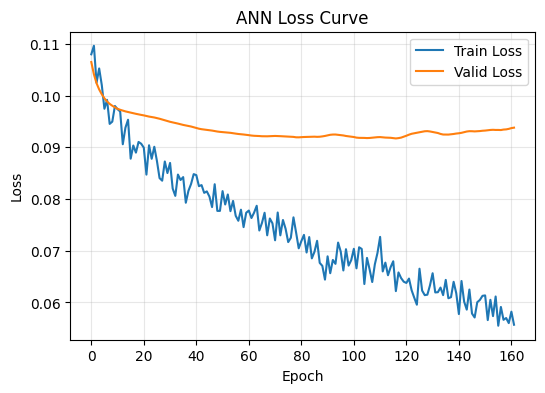

Best params for ANN: OrderedDict([('clf__criterion__alpha', 0.3079785193192187), ('clf__criterion__gamma', 1.0), ('clf__lr', 9.904709380938371e-05), ('clf__module__dropout_rate', 0.42816886771846785), ('clf__module__hidden_dim', 188), ('clf__module__num_layers', 2)])
Tuned threshold for ANN: 0.42 (Log-Rank Chi2=150.528)
ANN: AP=0.655, ROC AUC=0.667
Tuned threshold for Ensemble: 0.46 (Log-Rank Chi2=214.450)


In [10]:
summary_df, curves_summary, metrics_results, metrics_df, survival_results, y_CGGA = train_evaluate_model(random_state=24,inner_folds=5,inner_iterations=200,ANN_iterations=200)

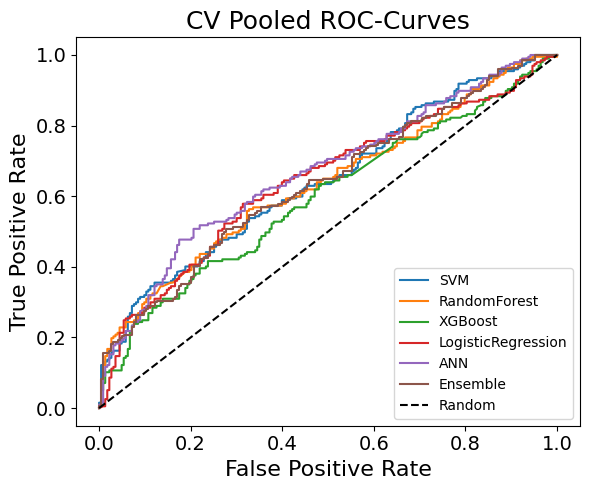

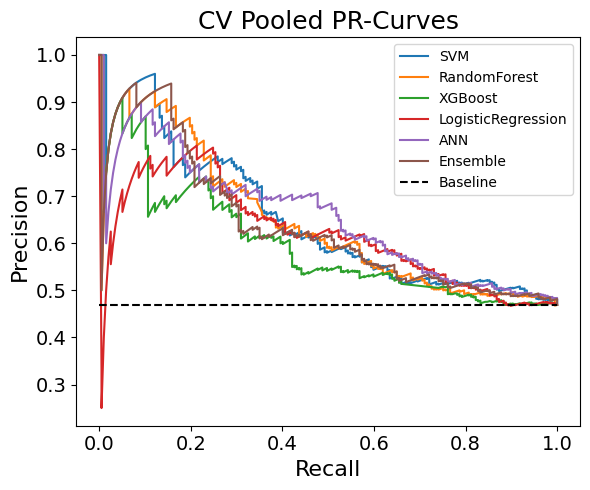

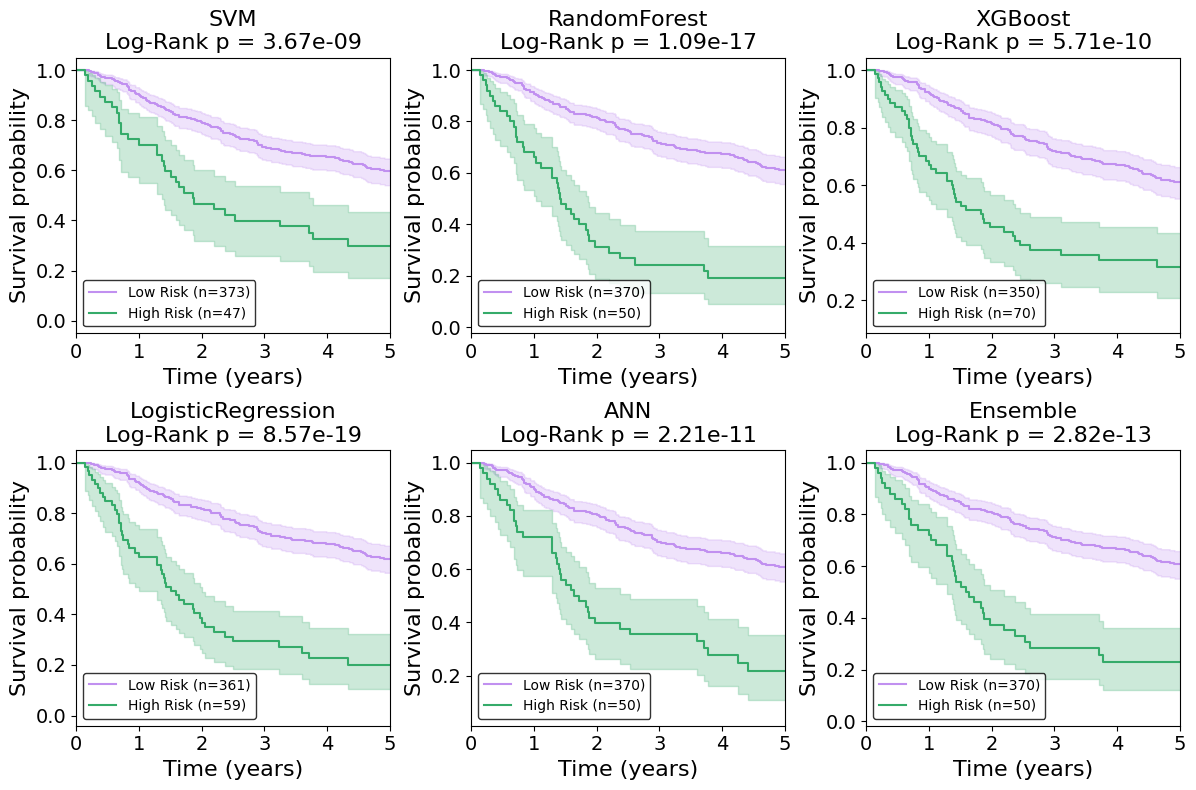

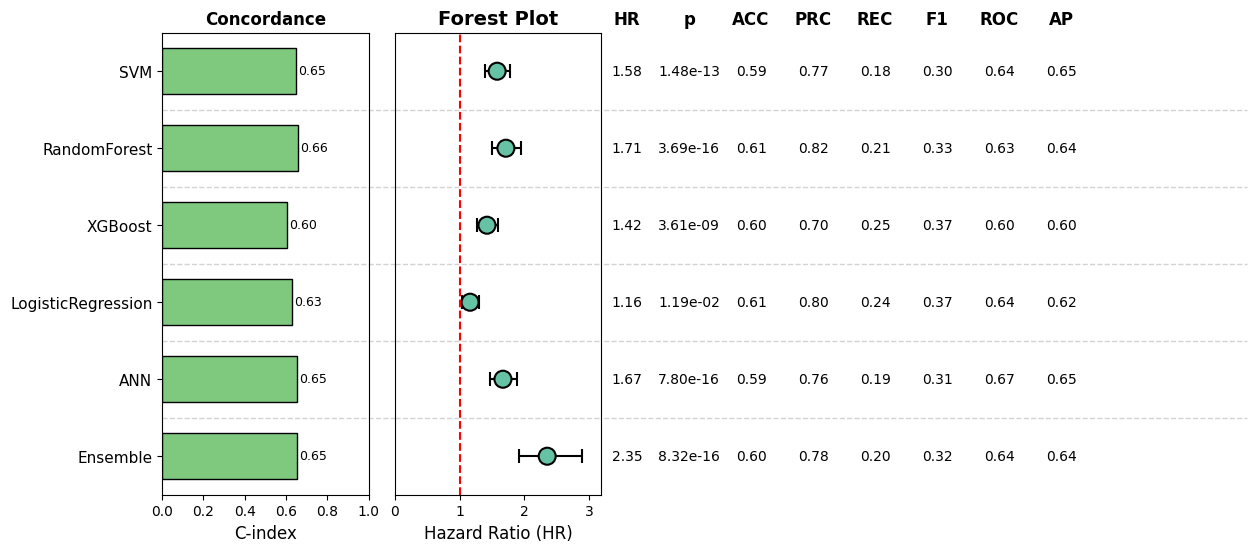

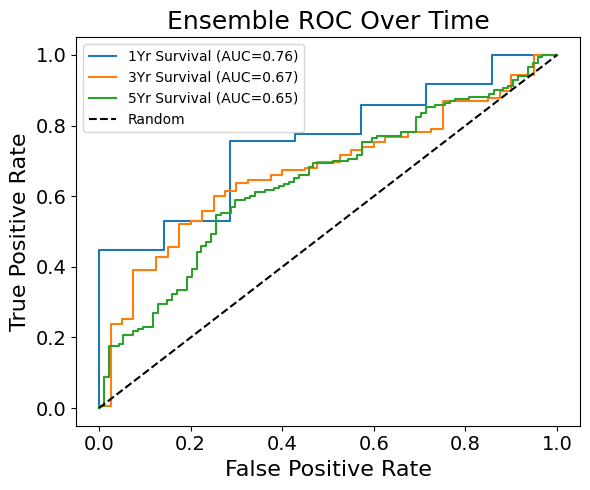

In [11]:
plot_mean_roc(curves_summary)
plot_mean_pr(curves_summary, y_CGGA)
plot_km_curves(survival_results,max_years=5)
plot_forest(survival_results=survival_results,metrics_results=metrics_results)
plot_time_roc(summary_df)
# plot_decision_curve(summary_df)

Exporting predictions with CGGA_IDS

In [12]:
summary_df.to_csv("./CGGA_Data/CGGA_Results.csv",index=False)